In [ ]:
!pip install pytorch_model_summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets
import time
from torch import nn, optim
from tqdm import tqdm
from pytorch_model_summary import summary
import pickle

In [ ]:
import torch
from torch.optim import Optimizer
import math
from collections import defaultdict

class AdamSGDWeighted(Optimizer):
    r"""Implements Adam, SGD and DFE mix algorithm.
    """

    def __init__(self,
                 params, lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,
                 adam_w=0.3, sgd_w=0.3, transform='linear'):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(
            lr=lr, weight_decay=weight_decay,
            betas=betas, eps=eps, amsgrad=amsgrad,
            momentum=momentum, dampening=dampening, nesterov=nesterov,
            adam_w=adam_w, sgd_w=sgd_w
        )
        super(AdamSGDWeighted, self).__init__(params, defaults)
        self.eps = eps
        self.transform = transform
    def __setstate__(self, state):
        super(AdamSGDWeighted, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('AdamSGDDFEWeighted does not support sparse gradients')

                d_p_adam, step_size = self.adam_step(grad, group, p)

                d_p_sgd = self.sgd_step(grad, group, p)
                
                if self.transform == 'polynomial':
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * (d_p_adam**2 + d_p_adam) 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )

                elif self.transform == 'linear':
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * d_p_adam 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )

                elif self.transform == 'correction':
                    
                    if torch.sum(d_p_sgd * d_p_adam) > 0: 
                        megred_d_p = group['sgd_w'] * d_p_sgd 
                        merged_lr = group['sgd_w'] * group['lr'] 
                    else:
                        megred_d_p = group['adam_w'] * d_p_adam 
                        merged_lr = group['adam_w'] * step_size 

                    merged_lr = group['sgd_w'] * group['lr'] + group['adam_w'] * step_size 

                elif self.transform == 'normalized':
                    megred_d_p = group['sgd_w'] * step_size * d_p_sgd/torch.norm(d_p_adam)
                    merged_lr = group['sgd_w'] * group['lr']

                elif self.transform == 'vector_combine':
                    d_p_sgd[d_p_sgd.shape[0]//2:] = 0
                    d_p_adam[:d_p_sgd.shape[0]//2] = 0
                    megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * d_p_adam 
                    merged_lr = (group['sgd_w'] * group['lr'] + group['adam_w'] * step_size )/2

                p.add_(megred_d_p, alpha=-merged_lr)

        return loss

    def adam_step(self, grad, group, p):
        amsgrad = group['amsgrad']
        state = self.state[p]
        # State initialization
        if len(state) == 0:
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            # Exponential moving average of squared gradient values
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            if amsgrad:
                # Maintains max of all exp. moving avg. of sq. grad. values
                state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        if amsgrad:
            max_exp_avg_sq = state['max_exp_avg_sq']
        beta1, beta2 = group['betas']
        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']
        if group['weight_decay'] != 0:
            grad = grad.add(p, alpha=group['weight_decay'])
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        step_size = group['lr'] / bias_correction1

        d_p = exp_avg / denom
        return d_p, step_size

    def sgd_step(self, grad, group, p):
        d_p = grad
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']
        if weight_decay != 0:
            d_p = d_p.add(p, alpha=weight_decay)
        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        return d_p
    

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3, 32, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(32, 64, 5)
        # self.fc1 = nn.Linear(64 * 5 * 5, 312)
        # self.fc2 = nn.Linear(312, 84)

        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 312),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(312, 84),
            nn.Dropout(),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)

        x = self.base(x)
        x = self.fc3(x)
        return x

In [14]:
def train(model,trainloader,testloader, nb_epochs = 100, eta = 1e-3, adam_w=0.5, sgd_w=0.5, transform='linear', mix='Mix'):
    
    criterion = nn.CrossEntropyLoss()
    if mix == 'Mix':
      optimizer = AdamSGDWeighted(model.parameters(), lr=eta, momentum=0, adam_w=adam_w, sgd_w=sgd_w, transform=transform)
    elif mix == 'Adam':
      optimizer = optim.Adam(cnn.parameters(), lr=eta)
    elif mix == 'SGD':
      optimizer = optim.SGD(cnn.parameters(), lr=eta, momentum=0.9)

    acc_val = []
    loss_train = []
    loss_val = []

    for e in range(nb_epochs):
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda() # add this line
            outputs = model(inputs)

            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            if mix == 'Mix': 
              optimizer.step(lambda: float(loss))
            else:
              optimizer.step()

            # print statistics
            running_loss += loss.item()
            rep = 2000
            if i % rep == 1999:    # print every 2000 mini-batches
                loss_train.append(running_loss/rep)
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i + 1, running_loss / rep))
                running_loss = 0.0
                correct = 0
                total = 0
                # since we're not training, we don't need to calculate the gradients for our outputs
                with torch.no_grad():
                    rloss_val = 0
                    for data in testloader:
                        images, labels = data
                        images, labels = images.cuda(), labels.cuda()

                        # calculate outputs by running images through the network
                        outputs = model(images)
                        rloss = criterion(outputs, labels)
                        rloss_val += rloss.item()

                        # the class with the highest energy is what we choose as prediction
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('Accuracy of the network on the 10000 test images: %d %%' % (
                    100 * correct / total))
                acc_val.append(correct / total)
                loss_val.append(rloss_val/ total)
    return acc_val, loss_val



In [20]:
import time
import matplotlib.pyplot as plt
import numpy as np


# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

runs = 10
root_save = './drive/MyDrive/Logs/'

In [ ]:
device

device(type='cuda')

### Baseline

In [ ]:
# SGD
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc = []
histories_loss = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in tqdm(range(runs)):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, mix='SGD')
    histories_acc.append(history_acc)
    histories_loss.append(history_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy o

 10%|█         | 1/10 [14:47<2:13:06, 887.38s/it]

Accuracy of the network on the 10000 test images: 43 %
Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy o

 20%|██        | 2/10 [29:14<1:57:30, 881.33s/it]

Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 61 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy o

 30%|███       | 3/10 [43:34<1:42:05, 875.04s/it]

Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 test images: 52 %
Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 61 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy o

 40%|████      | 4/10 [57:59<1:27:10, 871.78s/it]

Accuracy of the network on the 10000 test images: 41 %
Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 55 %
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 62 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy o

 50%|█████     | 5/10 [1:12:28<1:12:35, 871.20s/it]

Accuracy of the network on the 10000 test images: 40 %
Accuracy of the network on the 10000 test images: 50 %
Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 58 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy o

 60%|██████    | 6/10 [1:26:43<57:44, 866.08s/it]  

Accuracy of the network on the 10000 test images: 41 %
Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 55 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy o

 70%|███████   | 7/10 [1:41:05<43:15, 865.06s/it]

Accuracy of the network on the 10000 test images: 43 %
Accuracy of the network on the 10000 test images: 52 %
Accuracy of the network on the 10000 test images: 57 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy o

 80%|████████  | 8/10 [1:55:20<28:43, 861.92s/it]

Accuracy of the network on the 10000 test images: 42 %
Accuracy of the network on the 10000 test images: 50 %
Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy o

 90%|█████████ | 9/10 [2:09:34<14:19, 859.52s/it]

Accuracy of the network on the 10000 test images: 41 %
Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 69 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy o

100%|██████████| 10/10 [2:23:46<00:00, 862.63s/it]


In [ ]:
with open(root_save+'sgd_acc.pkl','wb') as f:
  pickle.dump(histories_acc, f)

with open(root_save+'sgd_loss.pkl','wb') as f:
  pickle.dump(histories_loss, f)


In [ ]:
# Adam
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc0 = []
histories_loss0 = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in range(runs):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 50, eta=lr, adam_w=alpha, sgd_w=1-alpha, mix='Adam')
    histories_acc0.append(history_acc)
    histories_loss0.append(history_loss)

Accuracy of the network on the 10000 test images: 56 %
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy o

In [ ]:
with open(root_save+'adam_acc.pkl','wb') as f:
  pickle.dump(histories_acc0, f)

with open(root_save+'adam_loss.pkl','wb') as f:
  pickle.dump(histories_loss0, f)


### Linear combination

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='linear')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  1000] loss: 1.576
Accuracy of the network on the 10000 test images: 53 %
[1,  2000] loss: 1.278
Accuracy of the network on the 10000 test images: 54 %
[2,  1000] loss: 1.013
Accuracy of the network on the 10000 test images: 63 %
[2,  2000] loss: 1.004
Accuracy of the network on the 10000 test images: 64 %
[3,  1000] loss: 0.838
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.833
Accuracy of the network on the 10000 test images: 65 %
[4,  1000] loss: 0.683
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.732
Accuracy of the network on the 10000 test images: 66 %
[5,  1000] loss: 0.565
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.614
Accuracy of the network on the 10000 test images: 69 %
[6,  1000] loss: 0.480
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.522
Accuracy of the network on the 10000 test images: 68 %
[7,  1000] loss: 0.396
Accura

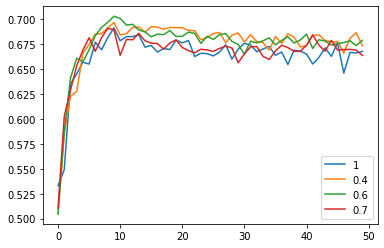

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(histories[0])),histories[0], label=alphas[0])
ax.plot(range(len(histories[1])),histories[1], label=alphas[1])
ax.plot(range(len(histories[2])),histories[2], label=alphas[2])
ax.plot(range(len(histories[3])),histories[3], label=alphas[3])
plt.legend()

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc1 = []
histories_loss1 = []

lr = 1e-3
alpha = 0.6
batch_size = 256


for i in range(runs):

    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader,nb_epochs = 50, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='linear')
    histories_acc1.append(history_acc)
    histories_loss1.append(history_loss)

[1,  1000] loss: 1.575
Accuracy of the network on the 10000 test images: 52 %
[1,  2000] loss: 1.265
Accuracy of the network on the 10000 test images: 56 %
[2,  1000] loss: 1.006
Accuracy of the network on the 10000 test images: 63 %
[2,  2000] loss: 0.980
Accuracy of the network on the 10000 test images: 63 %
[3,  1000] loss: 0.805
Accuracy of the network on the 10000 test images: 67 %
[3,  2000] loss: 0.797
Accuracy of the network on the 10000 test images: 68 %
[4,  1000] loss: 0.642
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.679
Accuracy of the network on the 10000 test images: 67 %
[5,  1000] loss: 0.507
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.556
Accuracy of the network on the 10000 test images: 68 %
[6,  1000] loss: 0.405
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.457
Accuracy of the network on the 10000 test images: 69 %
[7,  1000] loss: 0.318
Accuracy of the network on the 10000 test

In [ ]:
with open(root_save+'linear_acc.pkl','wb') as f:
  pickle.dump(histories_acc1, f)

with open(root_save+'linear_loss.pkl','wb') as f:
  pickle.dump(histories_loss1, f)


### Polynomial Combination

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='polynomial')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  1000] loss: 1.762
Accuracy of the network on the 10000 test images: 40 %
[1,  2000] loss: 1.679
Accuracy of the network on the 10000 test images: 39 %
[2,  1000] loss: 1.891
Accuracy of the network on the 10000 test images: 21 %
[2,  2000] loss: 1.889
Accuracy of the network on the 10000 test images: 35 %
[3,  1000] loss: 1.996
Accuracy of the network on the 10000 test images: 25 %
[3,  2000] loss: 2.064
Accuracy of the network on the 10000 test images: 15 %
[4,  1000] loss: 2.216
Accuracy of the network on the 10000 test images: 16 %
[4,  2000] loss: 2.240
Accuracy of the network on the 10000 test images: 15 %
[5,  1000] loss: 2.252
Accuracy of the network on the 10000 test images: 14 %
[5,  2000] loss: 2.261
Accuracy of the network on the 10000 test images: 15 %
[6,  1000] loss: 2.258
Accuracy of the network on the 10000 test images: 15 %
[6,  2000] loss: 2.250
Accuracy of the network on the 10000 test images: 15 %
[7,  1000] loss: 2.263
Accura

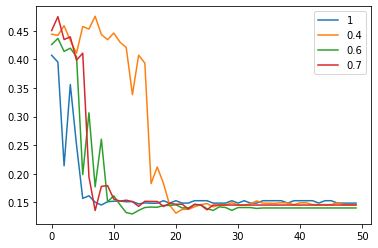

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(histories[0])),histories[0], label=alphas[0])
ax.plot(range(len(histories[1])),histories[1], label=alphas[1])
ax.plot(range(len(histories[2])),histories[2], label=alphas[2])
ax.plot(range(len(histories[3])),histories[3], label=alphas[3])
plt.legend()

### Correction

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='correction')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  2000] loss: 1.436
Accuracy of the network on the 10000 test images: 55 %
[2,  2000] loss: 1.024
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.842
Accuracy of the network on the 10000 test images: 66 %
[4,  2000] loss: 0.709
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.602
Accuracy of the network on the 10000 test images: 66 %
[6,  2000] loss: 0.501
Accuracy of the network on the 10000 test images: 66 %
[7,  2000] loss: 0.436
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.369
Accuracy of the network on the 10000 test images: 66 %
[9,  2000] loss: 0.325
Accuracy of the network on the 10000 test images: 66 %
[10,  2000] loss: 0.293
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.267
Accuracy of the network on the 10000 test images: 66 %
[12,  2000] loss: 0.237
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.231
Ac

In [ ]:
val_accuracies = np.array(histories)[:,0,:]
val_losses = np.array(histories)[:,1,:]

In [ ]:
plt.style.use('seaborn-whitegrid')
colors = ['lightcoral','palegreen','lightskyblue','plum']

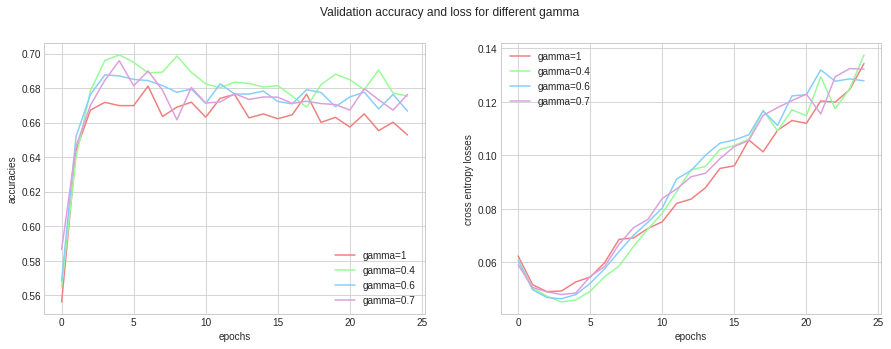

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i in range(4):
    ax[0].plot(range(len(val_accuracies[i])),val_accuracies[i], label='gamma='+str(alphas[i]), color=colors[i])
    ax[1].plot(range(len(val_losses[i])),val_losses[i], label='gamma='+str(alphas[i]), color=colors[i])



ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracies')

ax[1].set_xlabel('epochs')
ax[1].set_ylabel('cross entropy losses')

ax[0].legend()
ax[1].legend()
plt.suptitle('Validation accuracy and loss for different gamma')
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc2 = []
histories_loss2 = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in tqdm(range(runs)):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='correction')
    histories_acc2.append(history_acc)
    histories_loss2.append(history_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 1.419
Accuracy of the network on the 10000 test images: 56 %
[2,  2000] loss: 1.005
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.810
Accuracy of the network on the 10000 test images: 68 %
[4,  2000] loss: 0.672
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.549
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.447
Accuracy of the network on the 10000 test images: 69 %
[7,  2000] loss: 0.354
Accuracy of the network on the 10000 test images: 70 %
[8,  2000] loss: 0.287
Accuracy of the network on the 10000 test images: 69 %
[9,  2000] loss: 0.246
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.208
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.186
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.167
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.157
Accuracy of the network on the 10000 

 10%|█         | 1/10 [08:59<1:20:56, 539.62s/it]

[1,  2000] loss: 1.438
Accuracy of the network on the 10000 test images: 56 %
[2,  2000] loss: 1.019
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.824
Accuracy of the network on the 10000 test images: 68 %
[4,  2000] loss: 0.685
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.554
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.447
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.360
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.295
Accuracy of the network on the 10000 test images: 67 %
[9,  2000] loss: 0.242
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.213
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.178
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.170
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.150
Accuracy of the network on the 10000 

 20%|██        | 2/10 [17:52<1:11:40, 537.52s/it]

[1,  2000] loss: 1.431
Accuracy of the network on the 10000 test images: 55 %
[2,  2000] loss: 1.018
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.820
Accuracy of the network on the 10000 test images: 68 %
[4,  2000] loss: 0.674
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.556
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.452
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.357
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.294
Accuracy of the network on the 10000 test images: 67 %
[9,  2000] loss: 0.249
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.208
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.184
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.161
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.151
Accuracy of the network on the 10000 

 30%|███       | 3/10 [26:41<1:02:24, 534.89s/it]

[1,  2000] loss: 1.423
Accuracy of the network on the 10000 test images: 58 %
[2,  2000] loss: 1.009
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.825
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.674
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.553
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.445
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.360
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.291
Accuracy of the network on the 10000 test images: 67 %
[9,  2000] loss: 0.244
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.210
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.191
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.165
Accuracy of the network on the 10000 test images: 66 %
[13,  2000] loss: 0.161
Accuracy of the network on the 10000 

 40%|████      | 4/10 [35:30<53:20, 533.37s/it]  

[1,  2000] loss: 1.425
Accuracy of the network on the 10000 test images: 59 %
[2,  2000] loss: 0.980
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.792
Accuracy of the network on the 10000 test images: 68 %
[4,  2000] loss: 0.658
Accuracy of the network on the 10000 test images: 69 %
[5,  2000] loss: 0.540
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.436
Accuracy of the network on the 10000 test images: 69 %
[7,  2000] loss: 0.351
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.288
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.238
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.205
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.184
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.176
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.154
Accuracy of the network on the 10000 

 50%|█████     | 5/10 [44:16<44:15, 531.02s/it]

[1,  2000] loss: 1.420
Accuracy of the network on the 10000 test images: 58 %
[2,  2000] loss: 1.019
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.827
Accuracy of the network on the 10000 test images: 66 %
[4,  2000] loss: 0.685
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.563
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.453
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.371
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.295
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.251
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.214
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.187
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.169
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.160
Accuracy of the network on the 10000 

 60%|██████    | 6/10 [53:02<35:18, 529.57s/it]

[1,  2000] loss: 1.428
Accuracy of the network on the 10000 test images: 57 %
[2,  2000] loss: 1.013
Accuracy of the network on the 10000 test images: 63 %
[3,  2000] loss: 0.816
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.682
Accuracy of the network on the 10000 test images: 69 %
[5,  2000] loss: 0.546
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.445
Accuracy of the network on the 10000 test images: 69 %
[7,  2000] loss: 0.355
Accuracy of the network on the 10000 test images: 69 %
[8,  2000] loss: 0.291
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.247
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.206
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.181
Accuracy of the network on the 10000 test images: 66 %
[12,  2000] loss: 0.166
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.151
Accuracy of the network on the 10000 

 70%|███████   | 7/10 [1:01:50<26:27, 529.13s/it]

[1,  2000] loss: 1.426
Accuracy of the network on the 10000 test images: 58 %
[2,  2000] loss: 1.024
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.827
Accuracy of the network on the 10000 test images: 66 %
[4,  2000] loss: 0.679
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.553
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.448
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.357
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.294
Accuracy of the network on the 10000 test images: 67 %
[9,  2000] loss: 0.240
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.207
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.183
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.165
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.147
Accuracy of the network on the 10000 

 80%|████████  | 8/10 [1:10:42<17:39, 529.99s/it]

[1,  2000] loss: 1.426
Accuracy of the network on the 10000 test images: 58 %
[2,  2000] loss: 1.006
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.815
Accuracy of the network on the 10000 test images: 68 %
[4,  2000] loss: 0.666
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.542
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.434
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.343
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.282
Accuracy of the network on the 10000 test images: 69 %
[9,  2000] loss: 0.234
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.203
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.178
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.165
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.147
Accuracy of the network on the 10000 

 90%|█████████ | 9/10 [1:19:38<08:51, 531.67s/it]

[1,  2000] loss: 1.436
Accuracy of the network on the 10000 test images: 58 %
[2,  2000] loss: 1.016
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.821
Accuracy of the network on the 10000 test images: 68 %
[4,  2000] loss: 0.675
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.547
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.435
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.348
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.288
Accuracy of the network on the 10000 test images: 67 %
[9,  2000] loss: 0.238
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.204
Accuracy of the network on the 10000 test images: 66 %
[11,  2000] loss: 0.187
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.170
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.157
Accuracy of the network on the 10000 

100%|██████████| 10/10 [1:28:36<00:00, 531.63s/it]


In [ ]:
with open(root_save+'correction_acc.pkl','wb') as f:
  pickle.dump(histories_acc2, f)

with open(root_save+'correction_loss.pkl','wb') as f:
  pickle.dump(histories_loss2, f)


### Normalization

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='normalized')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  1000] loss: 1.578
Accuracy of the network on the 10000 test images: 52 %
[1,  2000] loss: 1.281
Accuracy of the network on the 10000 test images: 55 %
[2,  1000] loss: 1.022
Accuracy of the network on the 10000 test images: 63 %
[2,  2000] loss: 1.010
Accuracy of the network on the 10000 test images: 63 %
[3,  1000] loss: 0.826
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.838
Accuracy of the network on the 10000 test images: 66 %
[4,  1000] loss: 0.685
Accuracy of the network on the 10000 test images: 65 %
[4,  2000] loss: 0.734
Accuracy of the network on the 10000 test images: 66 %
[5,  1000] loss: 0.566
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.626
Accuracy of the network on the 10000 test images: 68 %
[6,  1000] loss: 0.495
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.529
Accuracy of the network on the 10000 test images: 68 %
[7,  1000] loss: 0.401
Accura

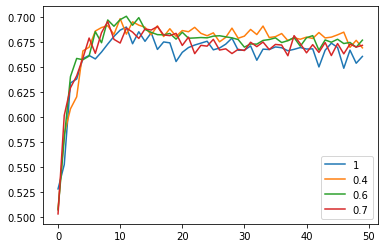

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(histories[0])),histories[0], label=alphas[0])
ax.plot(range(len(histories[1])),histories[1], label=alphas[1])
ax.plot(range(len(histories[2])),histories[2], label=alphas[2])
ax.plot(range(len(histories[3])),histories[3], label=alphas[3])
plt.legend()

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc3 = []
histories_loss3 = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in tqdm(range(runs)):

    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='normalized')
    histories_acc3.append(history_acc)
    histories_loss3.append(history_loss)



  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 1.424
Accuracy of the network on the 10000 test images: 56 %
[2,  2000] loss: 1.006
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.816
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.671
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.552
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.443
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.354
Accuracy of the network on the 10000 test images: 67 %
[8,  2000] loss: 0.292
Accuracy of the network on the 10000 test images: 69 %
[9,  2000] loss: 0.237
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.211
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.185
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.178
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.160
Accuracy of the network on the 10000 



 10%|█         | 1/10 [08:52<1:19:54, 532.77s/it]

[1,  2000] loss: 1.439
Accuracy of the network on the 10000 test images: 57 %
[2,  2000] loss: 1.018
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.822
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.683
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.556
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.447
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.361
Accuracy of the network on the 10000 test images: 67 %
[8,  2000] loss: 0.290
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.242
Accuracy of the network on the 10000 test images: 69 %
[10,  2000] loss: 0.214
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.186
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.163
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.166
Accuracy of the network on the 10000 



 20%|██        | 2/10 [17:49<1:11:12, 534.03s/it]

[1,  2000] loss: 1.436
Accuracy of the network on the 10000 test images: 55 %
[2,  2000] loss: 1.022
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.827
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.677
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.560
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.452
Accuracy of the network on the 10000 test images: 69 %
[7,  2000] loss: 0.358
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.297
Accuracy of the network on the 10000 test images: 69 %
[9,  2000] loss: 0.243
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.210
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.185
Accuracy of the network on the 10000 test images: 65 %
[12,  2000] loss: 0.168
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.154
Accuracy of the network on the 10000 



 30%|███       | 3/10 [26:42<1:02:14, 533.50s/it]

[1,  2000] loss: 1.428
Accuracy of the network on the 10000 test images: 57 %
[2,  2000] loss: 1.014
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.822
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.684
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.560
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.451
Accuracy of the network on the 10000 test images: 69 %
[7,  2000] loss: 0.365
Accuracy of the network on the 10000 test images: 69 %
[8,  2000] loss: 0.297
Accuracy of the network on the 10000 test images: 67 %
[9,  2000] loss: 0.255
Accuracy of the network on the 10000 test images: 69 %
[10,  2000] loss: 0.223
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.192
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.180
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.158
Accuracy of the network on the 10000 



 40%|████      | 4/10 [35:33<53:16, 532.75s/it]  

[1,  2000] loss: 1.435
Accuracy of the network on the 10000 test images: 58 %
[2,  2000] loss: 0.995
Accuracy of the network on the 10000 test images: 66 %
[3,  2000] loss: 0.805
Accuracy of the network on the 10000 test images: 68 %
[4,  2000] loss: 0.668
Accuracy of the network on the 10000 test images: 69 %
[5,  2000] loss: 0.546
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.445
Accuracy of the network on the 10000 test images: 69 %
[7,  2000] loss: 0.355
Accuracy of the network on the 10000 test images: 69 %
[8,  2000] loss: 0.293
Accuracy of the network on the 10000 test images: 69 %
[9,  2000] loss: 0.249
Accuracy of the network on the 10000 test images: 69 %
[10,  2000] loss: 0.202
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.186
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.169
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.158
Accuracy of the network on the 10000 



 50%|█████     | 5/10 [44:23<44:19, 531.94s/it]

[1,  2000] loss: 1.421
Accuracy of the network on the 10000 test images: 57 %
[2,  2000] loss: 1.019
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.835
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.688
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.562
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.452
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.367
Accuracy of the network on the 10000 test images: 67 %
[8,  2000] loss: 0.305
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.242
Accuracy of the network on the 10000 test images: 66 %
[10,  2000] loss: 0.216
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.183
Accuracy of the network on the 10000 test images: 66 %
[12,  2000] loss: 0.178
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.155
Accuracy of the network on the 10000 



 60%|██████    | 6/10 [53:17<35:30, 532.62s/it]

[1,  2000] loss: 1.436
Accuracy of the network on the 10000 test images: 56 %
[2,  2000] loss: 1.026
Accuracy of the network on the 10000 test images: 63 %
[3,  2000] loss: 0.822
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.690
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.558
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.451
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.366
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.294
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.244
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.210
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.183
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.173
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.154
Accuracy of the network on the 10000 



 70%|███████   | 7/10 [1:02:10<26:38, 532.79s/it]

[1,  2000] loss: 1.434
Accuracy of the network on the 10000 test images: 58 %
[2,  2000] loss: 1.034
Accuracy of the network on the 10000 test images: 62 %
[3,  2000] loss: 0.834
Accuracy of the network on the 10000 test images: 66 %
[4,  2000] loss: 0.691
Accuracy of the network on the 10000 test images: 69 %
[5,  2000] loss: 0.560
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.454
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.358
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.286
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.242
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.212
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.180
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.171
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.153
Accuracy of the network on the 10000 



 80%|████████  | 8/10 [1:11:05<17:46, 533.40s/it]

[1,  2000] loss: 1.434
Accuracy of the network on the 10000 test images: 57 %
[2,  2000] loss: 1.014
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.817
Accuracy of the network on the 10000 test images: 68 %
[4,  2000] loss: 0.676
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.547
Accuracy of the network on the 10000 test images: 69 %
[6,  2000] loss: 0.448
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.359
Accuracy of the network on the 10000 test images: 67 %
[8,  2000] loss: 0.289
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.236
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.216
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.179
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.170
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.146
Accuracy of the network on the 10000 



 90%|█████████ | 9/10 [1:20:00<08:53, 533.82s/it]

[1,  2000] loss: 1.442
Accuracy of the network on the 10000 test images: 59 %
[2,  2000] loss: 1.015
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.817
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.669
Accuracy of the network on the 10000 test images: 68 %
[5,  2000] loss: 0.539
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.432
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.344
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.282
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.236
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.202
Accuracy of the network on the 10000 test images: 66 %
[11,  2000] loss: 0.188
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.165
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.150
Accuracy of the network on the 10000 



100%|██████████| 10/10 [1:28:44<00:00, 532.43s/it]


In [ ]:
with open(root_save+'normalization_acc.pkl','wb') as f:
  pickle.dump(histories_acc3, f)

with open(root_save+'normalization_loss.pkl','wb') as f:
  pickle.dump(histories_loss3, f)


### Vector Combination

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3]
alphas = [1, 0.4, 0.6, 0.7]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = CNN().to(device)

    history = train(mlp, trainloader, testloader,nb_epochs = 25,eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='vector_combine')
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
[1,  1000] loss: 1.600
Accuracy of the network on the 10000 test images: 50 %
[1,  2000] loss: 1.318
Accuracy of the network on the 10000 test images: 54 %
[2,  1000] loss: 1.088
Accuracy of the network on the 10000 test images: 61 %
[2,  2000] loss: 1.071
Accuracy of the network on the 10000 test images: 61 %
[3,  1000] loss: 0.929
Accuracy of the network on the 10000 test images: 64 %
[3,  2000] loss: 0.921
Accuracy of the network on the 10000 test images: 62 %
[4,  1000] loss: 0.807
Accuracy of the network on the 10000 test images: 65 %
[4,  2000] loss: 0.829
Accuracy of the network on the 10000 test images: 65 %
[5,  1000] loss: 0.713
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.745
Accuracy of the network on the 10000 test images: 66 %
[6,  1000] loss: 0.640
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.671
Accuracy of the network on the 10000 test images: 67 %
[7,  1000] loss: 0.553
Accura

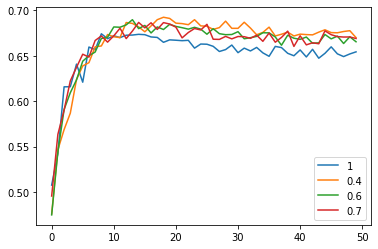

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(histories[0])),histories[0], label=alphas[0])
ax.plot(range(len(histories[1])),histories[1], label=alphas[1])
ax.plot(range(len(histories[2])),histories[2], label=alphas[2])
ax.plot(range(len(histories[3])),histories[3], label=alphas[3])
plt.legend()

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

histories_acc4 = []
histories_loss4 = []

lr = 1e-3
alpha = 0.6
batch_size = 256

for i in tqdm(range(runs)):
    cnn = CNN().to(device)
    history_acc,history_loss = train(cnn, trainloader, testloader, nb_epochs = 25, eta=lr, adam_w=alpha, sgd_w=1-alpha, transform='vector_combine')
    histories_acc4.append(history_acc)
    histories_loss4.append(history_loss)



  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 1.487
Accuracy of the network on the 10000 test images: 54 %
[2,  2000] loss: 1.114
Accuracy of the network on the 10000 test images: 61 %
[3,  2000] loss: 0.951
Accuracy of the network on the 10000 test images: 64 %
[4,  2000] loss: 0.836
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.740
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.667
Accuracy of the network on the 10000 test images: 69 %
[7,  2000] loss: 0.595
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.528
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.468
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.417
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.376
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.327
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.290
Accuracy of the network on the 10000 



 10%|█         | 1/10 [08:38<1:17:43, 518.21s/it]

[1,  2000] loss: 1.499
Accuracy of the network on the 10000 test images: 52 %
[2,  2000] loss: 1.123
Accuracy of the network on the 10000 test images: 61 %
[3,  2000] loss: 0.956
Accuracy of the network on the 10000 test images: 63 %
[4,  2000] loss: 0.844
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.746
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.664
Accuracy of the network on the 10000 test images: 67 %
[7,  2000] loss: 0.590
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.529
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.471
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.420
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.368
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.326
Accuracy of the network on the 10000 test images: 66 %
[13,  2000] loss: 0.288
Accuracy of the network on the 10000 



 20%|██        | 2/10 [17:15<1:09:02, 517.85s/it]

[1,  2000] loss: 1.491
Accuracy of the network on the 10000 test images: 53 %
[2,  2000] loss: 1.123
Accuracy of the network on the 10000 test images: 61 %
[3,  2000] loss: 0.956
Accuracy of the network on the 10000 test images: 64 %
[4,  2000] loss: 0.835
Accuracy of the network on the 10000 test images: 65 %
[5,  2000] loss: 0.748
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.670
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.601
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.545
Accuracy of the network on the 10000 test images: 69 %
[9,  2000] loss: 0.482
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.429
Accuracy of the network on the 10000 test images: 69 %
[11,  2000] loss: 0.377
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.334
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.299
Accuracy of the network on the 10000 



 30%|███       | 3/10 [25:54<1:00:27, 518.19s/it]

[1,  2000] loss: 1.497
Accuracy of the network on the 10000 test images: 54 %
[2,  2000] loss: 1.133
Accuracy of the network on the 10000 test images: 60 %
[3,  2000] loss: 0.974
Accuracy of the network on the 10000 test images: 63 %
[4,  2000] loss: 0.856
Accuracy of the network on the 10000 test images: 65 %
[5,  2000] loss: 0.761
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.680
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.606
Accuracy of the network on the 10000 test images: 67 %
[8,  2000] loss: 0.541
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.487
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.430
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.377
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.334
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.296
Accuracy of the network on the 10000 



 40%|████      | 4/10 [34:33<51:50, 518.49s/it]  

[1,  2000] loss: 1.502
Accuracy of the network on the 10000 test images: 54 %
[2,  2000] loss: 1.118
Accuracy of the network on the 10000 test images: 62 %
[3,  2000] loss: 0.938
Accuracy of the network on the 10000 test images: 63 %
[4,  2000] loss: 0.822
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.734
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.662
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.594
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.534
Accuracy of the network on the 10000 test images: 69 %
[9,  2000] loss: 0.475
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.424
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.377
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.336
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.299
Accuracy of the network on the 10000 



 50%|█████     | 5/10 [43:21<43:27, 521.41s/it]

[1,  2000] loss: 1.482
Accuracy of the network on the 10000 test images: 54 %
[2,  2000] loss: 1.117
Accuracy of the network on the 10000 test images: 61 %
[3,  2000] loss: 0.958
Accuracy of the network on the 10000 test images: 65 %
[4,  2000] loss: 0.842
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.756
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.673
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.606
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.539
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.475
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.424
Accuracy of the network on the 10000 test images: 66 %
[11,  2000] loss: 0.370
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.328
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.288
Accuracy of the network on the 10000 



 60%|██████    | 6/10 [52:19<35:05, 526.37s/it]

[1,  2000] loss: 1.504
Accuracy of the network on the 10000 test images: 53 %
[2,  2000] loss: 1.132
Accuracy of the network on the 10000 test images: 59 %
[3,  2000] loss: 0.958
Accuracy of the network on the 10000 test images: 64 %
[4,  2000] loss: 0.844
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.740
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.666
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.596
Accuracy of the network on the 10000 test images: 69 %
[8,  2000] loss: 0.529
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.474
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.417
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.365
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.327
Accuracy of the network on the 10000 test images: 68 %
[13,  2000] loss: 0.285
Accuracy of the network on the 10000 



 70%|███████   | 7/10 [1:01:17<26:29, 529.75s/it]

[1,  2000] loss: 1.500
Accuracy of the network on the 10000 test images: 55 %
[2,  2000] loss: 1.113
Accuracy of the network on the 10000 test images: 61 %
[3,  2000] loss: 0.936
Accuracy of the network on the 10000 test images: 65 %
[4,  2000] loss: 0.818
Accuracy of the network on the 10000 test images: 67 %
[5,  2000] loss: 0.727
Accuracy of the network on the 10000 test images: 68 %
[6,  2000] loss: 0.654
Accuracy of the network on the 10000 test images: 68 %
[7,  2000] loss: 0.583
Accuracy of the network on the 10000 test images: 68 %
[8,  2000] loss: 0.519
Accuracy of the network on the 10000 test images: 68 %
[9,  2000] loss: 0.457
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.410
Accuracy of the network on the 10000 test images: 68 %
[11,  2000] loss: 0.364
Accuracy of the network on the 10000 test images: 68 %
[12,  2000] loss: 0.318
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.278
Accuracy of the network on the 10000 



 80%|████████  | 8/10 [1:10:15<17:44, 532.21s/it]

[1,  2000] loss: 1.493
Accuracy of the network on the 10000 test images: 54 %
[2,  2000] loss: 1.116
Accuracy of the network on the 10000 test images: 61 %
[3,  2000] loss: 0.957
Accuracy of the network on the 10000 test images: 63 %
[4,  2000] loss: 0.847
Accuracy of the network on the 10000 test images: 65 %
[5,  2000] loss: 0.749
Accuracy of the network on the 10000 test images: 66 %
[6,  2000] loss: 0.672
Accuracy of the network on the 10000 test images: 67 %
[7,  2000] loss: 0.600
Accuracy of the network on the 10000 test images: 67 %
[8,  2000] loss: 0.542
Accuracy of the network on the 10000 test images: 67 %
[9,  2000] loss: 0.475
Accuracy of the network on the 10000 test images: 67 %
[10,  2000] loss: 0.426
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.376
Accuracy of the network on the 10000 test images: 66 %
[12,  2000] loss: 0.336
Accuracy of the network on the 10000 test images: 66 %
[13,  2000] loss: 0.291
Accuracy of the network on the 10000 



 90%|█████████ | 9/10 [1:19:15<08:54, 534.75s/it]

[1,  2000] loss: 1.515
Accuracy of the network on the 10000 test images: 54 %
[2,  2000] loss: 1.132
Accuracy of the network on the 10000 test images: 60 %
[3,  2000] loss: 0.972
Accuracy of the network on the 10000 test images: 65 %
[4,  2000] loss: 0.856
Accuracy of the network on the 10000 test images: 66 %
[5,  2000] loss: 0.763
Accuracy of the network on the 10000 test images: 67 %
[6,  2000] loss: 0.682
Accuracy of the network on the 10000 test images: 67 %
[7,  2000] loss: 0.615
Accuracy of the network on the 10000 test images: 67 %
[8,  2000] loss: 0.549
Accuracy of the network on the 10000 test images: 67 %
[9,  2000] loss: 0.488
Accuracy of the network on the 10000 test images: 68 %
[10,  2000] loss: 0.433
Accuracy of the network on the 10000 test images: 67 %
[11,  2000] loss: 0.382
Accuracy of the network on the 10000 test images: 67 %
[12,  2000] loss: 0.340
Accuracy of the network on the 10000 test images: 67 %
[13,  2000] loss: 0.299
Accuracy of the network on the 10000 



100%|██████████| 10/10 [1:28:08<00:00, 528.83s/it]


In [ ]:
with open(root_save+'vector_acc.pkl','wb') as f:
  pickle.dump(histories_acc4, f)

with open(root_save+'vector_loss.pkl','wb') as f:
  pickle.dump(histories_loss4, f)


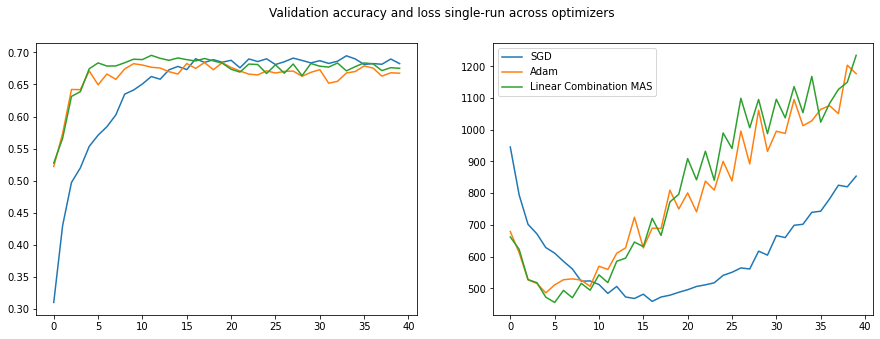

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(range(len(histories_acc[0])),histories_acc[0], label='SGD')
ax[0].plot(range(len(histories_acc0[0])),histories_acc0[0], label='Adam')
ax[0].plot(range(len(histories_acc1[0])),histories_acc1[0], label='Linear Combination MAS')

ax[1].plot(range(len(histories_acc[0])),histories_loss[0], label='SGD')
ax[1].plot(range(len(histories_acc0[0])),histories_loss0[0], label='Adam')
ax[1].plot(range(len(histories_acc1[0])),histories_loss1[0], label='Linear Combination MAS')

plt.suptitle('Validation accuracy and loss single-run across optimizers')
plt.legend()
plt.show()

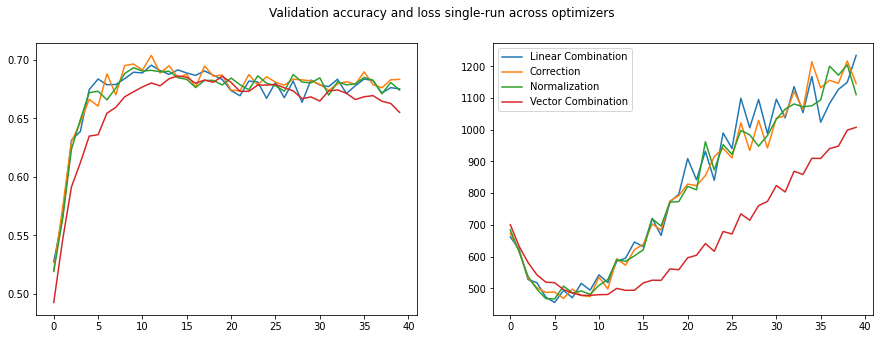

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(range(len(histories_acc1[0])),histories_acc1[0], label='Linear Combination')
ax[0].plot(range(len(histories_acc0[0])),histories_acc2[0], label='Correction')
ax[0].plot(range(len(histories_acc[0])),histories_acc3[0], label='Normalization')
ax[0].plot(range(len(histories_acc[0])),histories_acc4[0], label='Vector Combination')

ax[1].plot(range(len(histories_acc1[0])),histories_loss1[0], label='Linear Combination')
ax[1].plot(range(len(histories_acc0[0])),histories_loss2[0], label='Correction')
ax[1].plot(range(len(histories_acc[0])),histories_loss3[0], label='Normalization')
ax[1].plot(range(len(histories_acc[0])),histories_loss4[0], label='Vector Combination')


plt.suptitle('Validation accuracy and loss single-run across optimizers')
plt.legend()
plt.show()